Num GPUs Available:  0
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 73s 503ms/step - loss: 0.0501 - val_loss: 0.0256
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 59s 411ms/step - loss: 0.0240 - val_loss: 0.0206
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 89s 469ms/step - loss: 0.0197 - val_loss: 0.0179
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 60s 424ms/step - loss: 0.0176 - val_loss: 0.0168
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 58s 412ms/step - loss: 0.0164 - val_loss: 0.0159
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 58s 413ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 58s 412ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 416ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 9/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 418ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 10/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 415ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 59s 405ms/step - loss: 0.0582 - val_loss: 0.0352
Epoch 2/20
141/141 ━

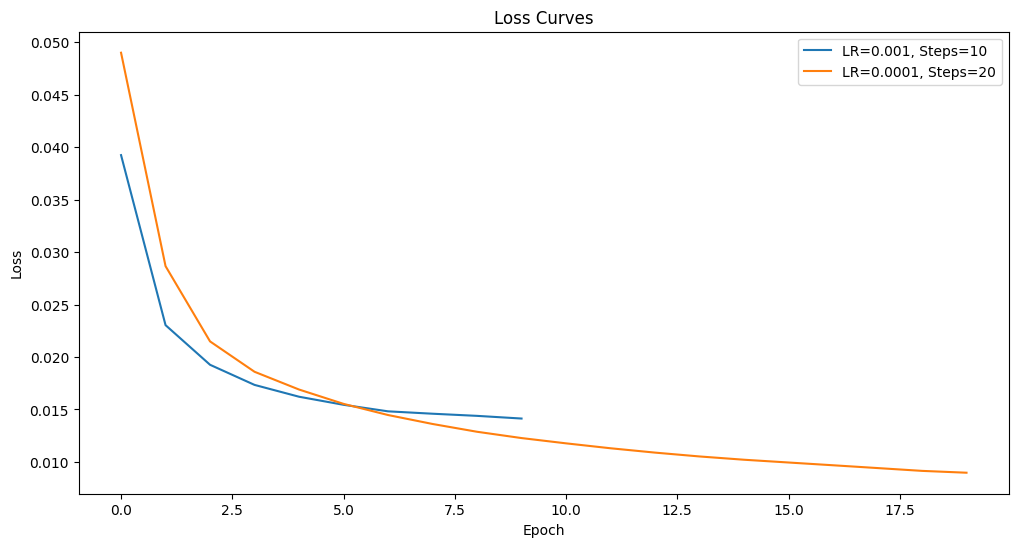

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Define the diffusion model architecture
def build_diffusion_model():
    model = Sequential([
        Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(32, 32, 3)),
        Conv2D(32, kernel_size=3, activation='relu', padding='same'),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(32 * 32 * 3, activation='sigmoid'),
        Reshape((32, 32, 3))
    ])
    return model

# Define the training process with early stopping
def train_diffusion_model(model, x_train, learning_rate, num_steps):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(x_train, x_train, epochs=num_steps, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
    return history

# Load CIFAR-10 dataset
(x_train, _), (_, _) = cifar10.load_data()
x_train = x_train / 255.0  # Normalize images
x_train = x_train[:5000]  # Use only the first 5000 samples

# Hyperparameters with fewer steps
hyperparameters = [
    {'learning_rate': 0.001, 'num_steps': 10},
    {'learning_rate': 0.0001, 'num_steps': 20}
]

# Train models and plot loss curves
plt.figure(figsize=(12, 6))
for params in hyperparameters:
    model = build_diffusion_model()
    history = train_diffusion_model(model, x_train, params['learning_rate'], params['num_steps'])
    plt.plot(history.history['loss'], label=f"LR={params['learning_rate']}, Steps={params['num_steps']}")

plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


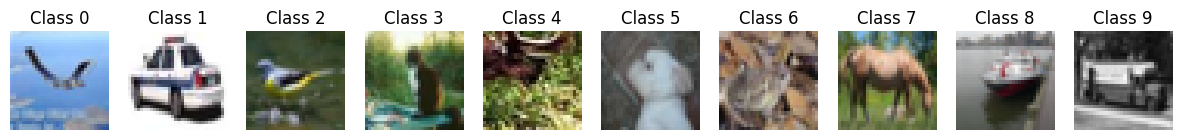

In [6]:
def generate_samples(model, num_classes=10):
    (x_train, y_train), (_, _) = cifar10.load_data()
    class_samples = []

    for i in range(num_classes):
        class_images = x_train[y_train.flatten() == i]
        sample_image = class_images[np.random.choice(len(class_images))]
        sample_image = sample_image / 255.0  # Normalize
        class_samples.append(sample_image)

    return class_samples

# Load and generate samples
samples = generate_samples(build_diffusion_model())

# Display samples
plt.figure(figsize=(15, 5))
for i, sample in enumerate(samples):
    plt.subplot(1, 10, i + 1)
    plt.title(f'Class {i}')
    plt.imshow(sample)
    plt.axis('off')

plt.show()


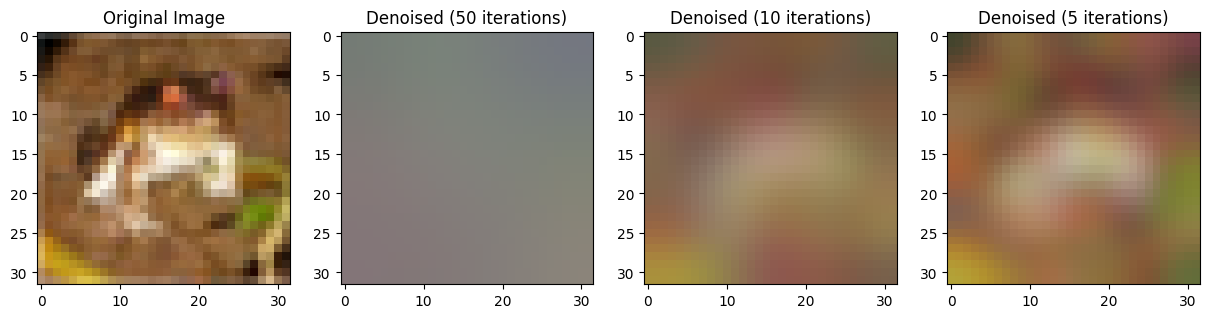

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 image
def load_cifar10_image(index=0):
    (x_train, _), (_, _) = cifar10.load_data()
    image = x_train[index] / 255.0  # Normalize image to [0, 1]
    return image

# Simplified diffusion and denoising
def diffusion_process(image, noise_level, num_iterations):
    noisy_image = image.copy()
    for _ in range(num_iterations):
        noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
        noisy_image = noisy_image + noise
        noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image

def denoise(image, steps):
    denoised_image = image.copy()
    for _ in range(steps):
        denoised_image = cv2.GaussianBlur(denoised_image, (5, 5), 0)
    return np.clip(denoised_image, 0, 1)

# Denoising with different iterations
def denoise_samples(image, iterations_list):
    denoised_images = []
    for iterations in iterations_list:
        noisy_image = diffusion_process(image, noise_level=0.1, num_iterations=iterations)
        denoised_image = denoise(noisy_image, steps=iterations)
        denoised_images.append(denoised_image)
    return denoised_images

# Process image and denoise
image = load_cifar10_image(index=0)
iterations_list = [50, 10, 5]
denoised_images = denoise_samples(image, iterations_list)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(image)

for i, steps in enumerate(iterations_list):
    plt.subplot(1, 4, i + 2)
    plt.title(f'Denoised ({steps} iterations)')
    plt.imshow(denoised_images[i])

plt.show()
